# Importing dependencies

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from tabulate import tabulate
from arch import arch_model
from arch.__future__ import reindexing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
import arch
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

# Acquiring TSLA stock data

In [3]:
data = pd.read_csv("TSLA_2022.csv")

In [4]:
df = pd.read_csv("SP_SC.csv")

In [5]:
data.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
241,2022-12-16,159.639999,160.990005,150.039993,150.229996,150.229996,139032200
242,2022-12-19,154.000000,155.250000,145.820007,149.869995,149.869995,139390600
243,2022-12-20,146.050003,148.470001,137.660004,137.800003,137.800003,159563300
244,2022-12-21,139.339996,141.259995,135.889999,137.570007,137.570007,145417400
245,2022-12-22,136.000000,136.630005,122.260002,125.349998,125.349998,210090300
246,2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700
247,2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400
248,2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500
249,2022-12-29,120.389999,123.570000,117.500000,121.820000,121.820000,221923300
250,2022-12-30,119.949997,124.480003,119.750000,123.180000,123.180000,157777300


# Calculating and plotting the daily returns

In [6]:
data['Return'] = 100 * (data['Adj Close'].pct_change())

Text(0.5, 1.0, 'Daily Returns Over Time')

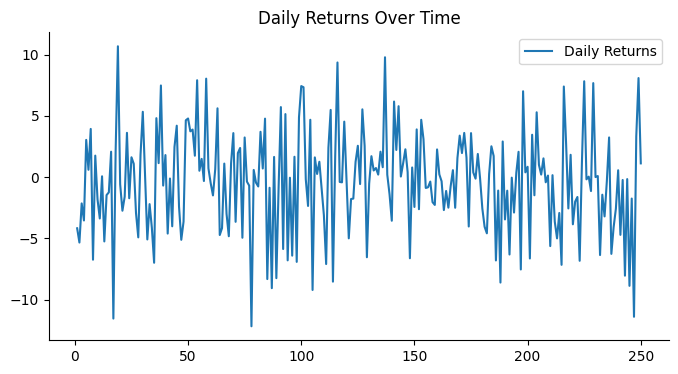

In [7]:
data.dropna(inplace=True)

fig,ax = plt.subplots(figsize=(8,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(data['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')

# Calculating daily, monthly and annual volatility

In [8]:

daily_volatility = data['Return'].std()

monthly_volatility = math.sqrt(21) * daily_volatility

annual_volatility = math.sqrt(252) * daily_volatility

print(tabulate([['Tesla',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Tesla │         4.12         │         18.86          │         65.33         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


# Statistical Test | PART I.

#### Augmented Dickey-Fuller Test (ADF) / Test for stationarity

In [9]:
# Testing for stationarity in the data ('Returns' column)
# H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time
# H1: The time series is stationary

adfuller(data["Return"])

# Test statistic: -4.10658
# p-value: 0.00094
# Conlclusion: p-value < 0, so H0 is rejected. The returns are stationary

(-4.106586702076152,
 0.0009445273454100348,
 8,
 241,
 {'1%': -3.4577787098622674,
  '5%': -2.873608704758507,
  '10%': -2.573201765981991},
 1318.264829870127)

#### [CHECK AGAIN LATER!!!] / Jarque-Bera Test / Testing if the returns are normally distributed


In [10]:
# Why is it important? To see what distribution is best when fitting the GARCH models
# H0: The data follows a normal distribution
# H1: The data does not follow a normal distribution

# DOES NOT MAKE SENSE - returns not supposed to follow a normal distrubution but the test says so

#perform Jarque-Bera test
stats.jarque_bera(data["Return"])

# Null hypothesis is failed to be rejected
# The data seems to be following a normal distribution

SignificanceResult(statistic=0.9986487015255834, pvalue=0.606940600162593)

# ACF & PACF 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


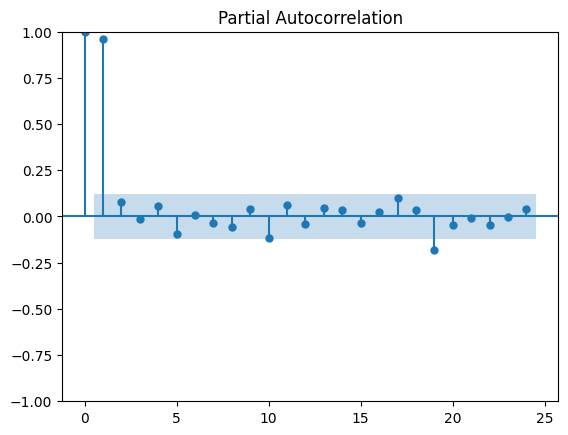

In [11]:
plot_pacf(data['Adj Close']**2)
plt.show()

# Normalizing our x values so that it fits the GARCH

In [12]:
# df['reg_output'] = (df['reg_output'] - np.min(df['reg_output']) + 1) / (np.max(df['reg_output']) - np.min(df['reg_output']) + 1)

# # min(x_normalized)

In [13]:
# create two new columns
df['reg_output_below_0.5'] = np.where(df['reg_output'] < 0, df['reg_output'], np.nan)
df['reg_output_above_0.5'] = np.where(df['reg_output'] >= 0, df['reg_output'], np.nan)

# fill the dummy values
df['reg_output_below_0.5'].fillna(0, inplace=True)
df['reg_output_above_0.5'].fillna(0, inplace=True)

# display the resulting dataframe
df


,Date,Open,High,Low,Close,Adj Close,Volume,date,created_utc,reg_output,reg_output_below_0.5,reg_output_above_0.5
0,2022-01-03,382.583344,400.356659,378.679993,399.926666,399.926666,103931400,2022-01-03,1.641161e+09,-0.060627,-0.060627,0.000000
1,2022-01-04,396.516663,402.666656,374.350006,383.196655,383.196655,100248300,2022-01-04,1.641242e+09,-0.101193,-0.101193,0.000000
2,2022-01-05,382.216675,390.113342,360.336670,362.706665,362.706665,80119800,2022-01-05,1.641334e+09,-0.218186,-0.218186,0.000000
3,2022-01-06,359.000000,362.666656,340.166656,354.899994,354.899994,90336600,2022-01-06,1.641426e+09,-0.204311,-0.204311,0.000000
4,2022-01-07,360.123322,360.309998,336.666656,342.320007,342.320007,84164700,2022-01-07,1.641517e+09,-0.248822,-0.248822,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
246,2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700,2022-12-23,1.671745e+09,-0.010171,-0.010171,0.000000
247,2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400,2022-12-27,1.672101e+09,0.010060,0.000000,0.010060
248,2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500,2022-12-28,1.672179e+09,-0.110069,-0.110069,0.000000
249,2022-12-29,120.389999,123.570000,117.500000,121.820000,121.820000,221923300,2022-12-29,1.672266e+09,0.016799,0.000000,0.016799


In [14]:
# count the values in column A
counts = df['reg_output_above_0.5'].value_counts()

# print the counts
print(counts)

0.000000    228
0.037043      1
0.010060      1
0.038096      1
0.021753      1
0.032996      1
0.002279      1
0.027167      1
0.038581      1
0.027168      1
0.162847      1
0.315456      1
0.155778      1
0.024143      1
0.200941      1
0.249042      1
0.144639      1
0.281442      1
0.013219      1
0.026576      1
0.015475      1
0.049528      1
0.011162      1
0.016799      1
Name: reg_output_above_0.5, dtype: int64


In [15]:
min(df['reg_output'])

-0.6212820595052714

# Fitting a GARCH(1,1) model with normal distribution

In [16]:
garch_model = arch_model(data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 1) # Q:What does horizon mean here?
print(gm_forecast.variance[-1:])              # A:The nr of steps ahead FC

mu         -0.364821
omega       0.768792
alpha[1]    0.020109
beta[1]     0.935147
Name: params, dtype: float64


           h.1
250  19.726717


In [17]:
gm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -707.531
Distribution:                  Normal   AIC:                           1423.06
Method:            Maximum Likelihood   BIC:                           1437.15
                                        No. Observations:                  250
Date:                Wed, Mar 15 2023   Df Residuals:                      249
Time:                        10:24:00   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.3648      0.266     -1.373      0.170 [ -0.886,  0.156]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.7688      0.490      1.568      0.117      [ -0.192,  1.729]
alpha[1]       0.0201  2.653e-02      0.758      0.449 [-3.190e-02,7.211e-02]
beta[1]        0.9351  2.563e-02     36.486 1.839e-291      [  0.885,  0.985]
=============================================================================

Covariance estimator: robust
"""

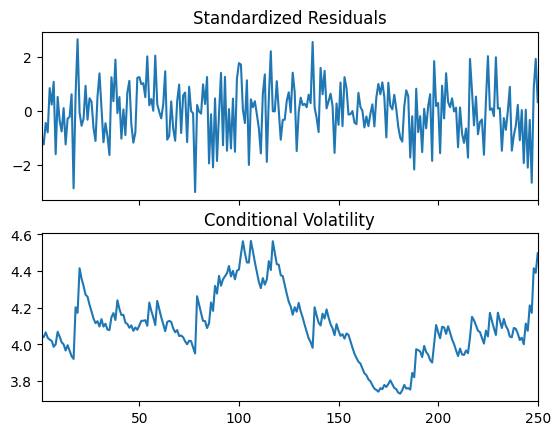

In [18]:
# Plot fitted results of GARCH (1,1)
gm_result.plot()
plt.show()

<Figure size 700x400 with 0 Axes>

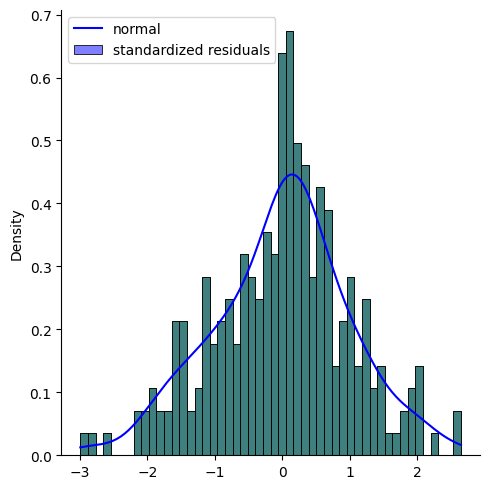

In [19]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid / gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.displot(gm_std_resid, kde=True, stat="density", bins=50, color='b')
sns.histplot(gm_std_resid, stat="density", bins=50, color='g', alpha=0.5)
plt.legend(('normal', 'standardized residuals'))
plt.show()

# Statistical Tests | PART II.

#### Ljung-Box Test on the residuals

In [36]:
# H0: The residuals are independently distributed
# H1: The residuals are not independently distributed; they exhibit serial correlation

sm.stats.acorr_ljungbox(gm_resid, lags=[25], return_df=True)

# p-value is less than 0.5, therefore the residuals exhibit serial correlation
# The GARCH(1,1) model is designed to capture the conditional heteroskedasticity 
#   in the data, and assuming that the model is correctly specified, the residuals 
#       should be independent and identically distributed. Any significant serial 
#           correlation in the residuals suggests that the model is not fully capturing 
#               the conditional heteroskedasticity or other patterns in the data

#NOTE: maybe we can try to adjust the number of lags

,lb_stat,lb_pvalue
25,41.003154,0.02294


#### Jarque-Bera Test on the residuals / Test for normality in the residuals

In [21]:
# H0: The residuals follows a normal distribution
# H1: The residuals does not follow a normal distribution

stats.jarque_bera(gm_resid)

# same as doing the tests for the returns (???)

SignificanceResult(statistic=0.9986487015255857, pvalue=0.6069406001625923)

# Fitting a GARCH(1,1) model with skewed t-distribution

In [22]:
# Specify GARCH model assumptions
skewt_gm = arch_model(data['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

In [23]:
skewt_result.summary()
# AIC and BIC are higher than the GARCH (1,1) fitted with normal distribution

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                            Return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -706.572
Distribution:      Standardized Skew Student's t   AIC:                           1425.14
Method:                       Maximum Likelihood   BIC:                           1446.27
                                                   No. Observations:                  250
Date:                           Wed, Mar 15 2023   Df Residuals:                      249
Time:                                   10:24:09   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.3848      0.267     -1.441      0.150 [ -0.908,  0.139]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.6411      0.465      1.378      0.168      [ -0.271,  1.553]
alpha[1]       0.0276  2.775e-02      0.995      0.320 [-2.677e-02,8.199e-02]
beta[1]        0.9356  2.554e-02     36.634 8.221e-294      [  0.886,  0.986]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
eta           25.1696     38.910      0.647      0.518 [-51.092,1.014e+02]
lambda        -0.1027  6.573e-02     -1.563      0.118 [ -0.232,2.608e-02]
==========================================================================

Covariance estimator: robust
"""

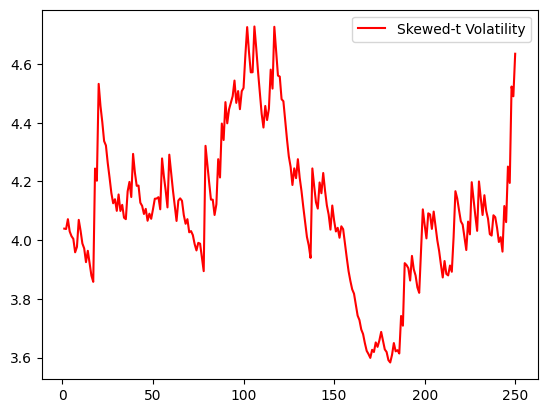

In [24]:
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.legend(loc = 'upper right')
plt.show()

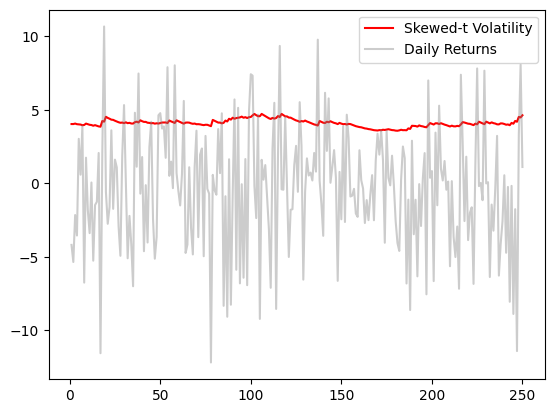

In [25]:
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(data['Return'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

# When plotting the model together with the returns, it is clear the model does not perform well / also what the information criteria indicates

# Fitting a GJR GARCH (1,1) model

In [26]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(data['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 'normal')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -703.660
Distribution:                  Normal   AIC:                           1417.32
Method:            Maximum Likelihood   BIC:                           1434.93
                                        No. Observations:                  250
Date:                Wed, Mar 15 2023   Df Residuals:                      249
Time:                        10:24:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.4254      0.245     -1.739  8.208e-02 [ -0.905,

# Fitting an E-GARCH(1,1) model

In [27]:
# Specify EGARCH model assumptions
egarch_gm = arch_model(data['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 'normal')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')
print(egarch_result.params)

# Print model fitting summary
print(egarch_result.summary())

mu         -0.255748
omega       0.053010
alpha[1]   -0.108862
gamma[1]   -0.072915
beta[1]     0.979780
Name: params, dtype: float64
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -697.756
Distribution:                  Normal   AIC:                           1405.51
Method:            Maximum Likelihood   BIC:                           1423.12
                                        No. Observations:                  250
Date:                Wed, Mar 15 2023   Df Residuals:                      249
Time:                        10:24:15   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
---------

# Compare GJR GARCH with E-GARCH

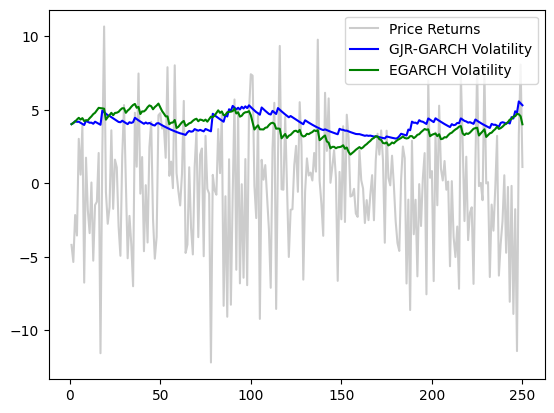

In [28]:
gjrgm_vol = gjrgm_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility

# Plot the actual stock returns
plt.plot(data['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'green', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

# EGARCH MODEL V2

In [ ]:
#https://www.oreilly.com/library/view/machine-learning-for/9781492085249/ch04.html#egarch_vol
# Define model
v2_egarch_sentiment = arch.arch_model(data['Return'],mean='constant', vol='EGARCH', p=1, o=1, q=1)

In [ ]:
#n = 252
#split_date = df['log_returns'].iloc[-n:].index 

In [ ]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch.arch_model(df['log_returns'], mean='constant', vol='EGARCH', p=p, q=q)\
                .fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch.arch_model(df['log_returns'], x=df['reg_output'], mean='constant', vol='EGARCH',
                    p=best_param[0], q=best_param[1])\
        .fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

In [ ]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                                  np.sqrt(forecast_garch\
                                  .variance.iloc[-len(split_date):]
                                  / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))
#The RMSE value of GARCH model is 0.0878

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100,
label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

# Combined EGARCH Model

In [ ]:
#https://bashtage.github.io/arch/univariate/univariate_forecasting_with_exogenous_variables.html
# Define model
egarch_sentiment = arch.arch_model(data['Return'], x=df[['reg_output']], mean='constant', vol='EGARCH', p=1, o=1, q=1)

In [ ]:
egarch_sentimentv1 = egarch_sentiment.fit()

In [ ]:
print(egarch_sentimentv1.summary())

# Pyflux EGARCH

In [ ]:
new_combined_egarch = model = pf.EGARCH(data=data, formula='Return~1+reg_output+sentiment', p=1, q=1, o=1)
#could not install pyflux on my pc

# [NOT USED] Rolling Predictions


In [ ]:
# training data size = 200 (80%)
# test data size = 50 (20%)

Text(0.5, 1.0, 'Rolling Prediction')

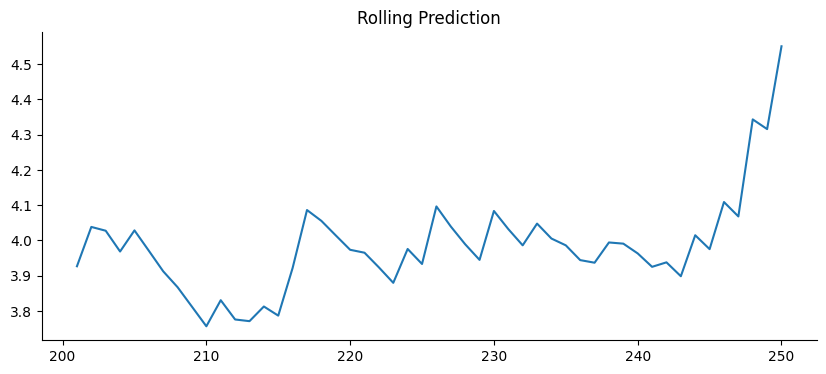

In [29]:
rolling_predictions = []
test_size = 50

for i in range(test_size):
    train = data['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1) #could the horizen be the number of periods we want to FC
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=data['Return'].index[-50:])

fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

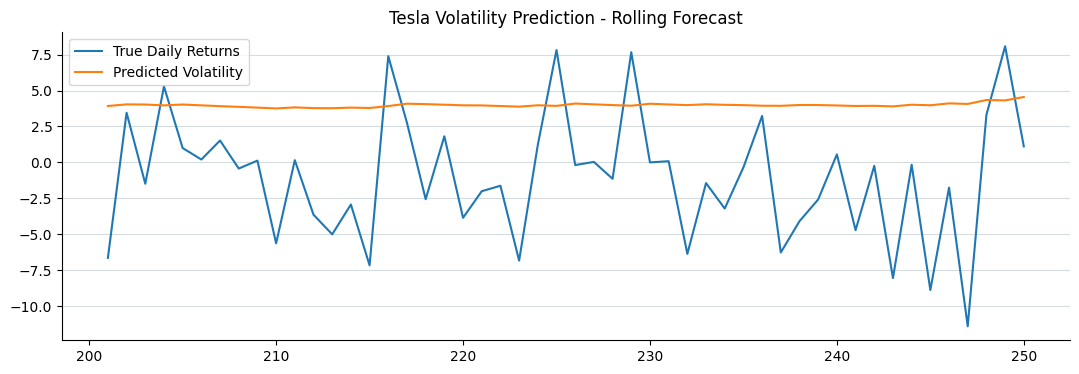

In [30]:
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(data['Return'][-50:])
plt.plot(rolling_predictions)
plt.title('Tesla Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])

# [NOT USED] Fitting the rolling prediction model and relevant statistics

In [31]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -705.049
Distribution:                  Normal   AIC:                           1418.10
Method:            Maximum Likelihood   BIC:                           1432.17
                                        No. Observations:                  249
Date:                Wed, Mar 15 2023   Df Residuals:                      248
Time:                        10:41:20   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.3668      0.267     -1.373      0.170 [ -0.890,  0.157]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.7690      0.500      1.538      0.124      [ -0.211,  1.749]
alpha[1]       0.0226  2.718e-02      0.832      0.406 [-3.067e-02,7.586e-02]
beta[1]        0.9331  2.658e-02     35.105 5.704e-270      [  0.881,  0.985]
=============================================================================

Covariance estimator: robust
"""